In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [26]:
df = pd.read_csv('C:/Users/odhia/OneDrive/Desktop/datascienceproject/data/clean_df.csv')
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,M,65,Yes,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Yes,NO
1,F,55,Yes,No,No,Yes,Yes,No,No,No,Yes,Yes,Yes,No,No,NO
2,F,78,No,No,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes,YES
3,M,60,No,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,YES
4,F,80,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,No,NO


In [27]:
cat_cols = ['smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic_disease', 'fatigue', 'allergy', 'wheezing',
       'alcohol_consuming', 'coughing', 'shortness_of_breath',
       'swallowing_difficulty', 'chest_pain']
for col in cat_cols:
    df[col] = df[col].map({'No':0,'Yes':1})
    

In [28]:
df.gender = df.gender.map({'M':1,'F':0})
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,1,65,1,1,1,0,0,1,0,0,0,0,0,0,1,NO
1,0,55,1,0,0,1,1,0,0,0,1,1,1,0,0,NO
2,0,78,0,0,1,1,1,0,1,0,1,1,0,1,1,YES
3,1,60,0,1,1,1,0,1,0,1,1,0,1,0,0,YES
4,0,80,1,1,0,1,1,0,1,0,1,1,1,1,0,NO


In [30]:
df['lung_cancer'] = df['lung_cancer'].map({'NO':0,'YES':1})

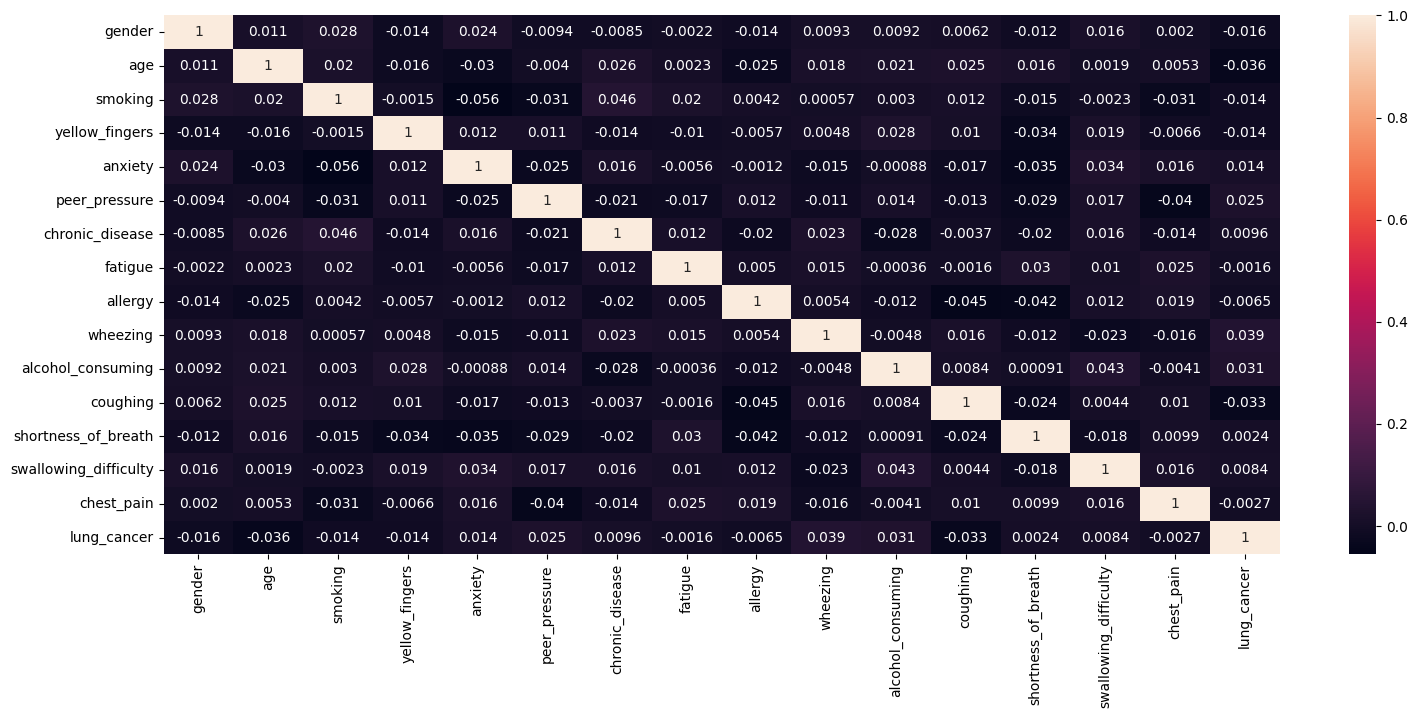

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,7))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [32]:
df.drop(['chronic_disease', 'fatigue', 'allergy','shortness_of_breath',
       'swallowing_difficulty', 'chest_pain'],axis=1,inplace=True)

In [34]:
X = df.drop('lung_cancer',axis=1)
y = df['lung_cancer']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
def hyperparameter_tune(model,params,x,y):
    grid = GridSearchCV(model,params,cv=2,return_train_score=False)
    grid.fit(x,y)
    result = grid.best_score_
    paras = grid.best_params_
    return f"Best parameters are; {paras} with score of {result}"

In [36]:
def evaluate_model(true,pred):
    accuracy = accuracy_score(true,pred)
    score = f1_score(true,pred)
    precision = precision_score(true,pred)
    recall = recall_score(true,pred)
    
    return (accuracy,score,precision,recall)

### Logistic regression

In [37]:
logistic = LogisticRegression()
logi_param = {'penalty':['l1','l2'],'solver':['liblinear','saga']}
hyperparameter_tune(logistic,logi_param,X_train,y_train)

"Best parameters are; {'penalty': 'l2', 'solver': 'liblinear'} with score of 0.5240213523131673"

In [38]:
def create_experiment(experiment_name,run_name):
    # creating experiment
    mlflow.set_tracking_uri("file:C:/Users/odhia/OneDrive/Desktop/datascienceproject/notebooks/logistic_mlruns")
    mlflow.set_experiment(experiment_name)
    #creating run within the experiment
    with mlflow.start_run(run_name=run_name):
        linear_model = LogisticRegression(penalty='l2',solver='liblinear')
        linear_model.fit(X_train,y_train)

        # Evaluate performance
        prediction = linear_model.predict(X_test)
        (accuracy,score,precision,recall) = evaluate_model(y_test,prediction)
        
        #print out metrics
        print(f"Accuracy: {accuracy}")
        print(f"F1_score: {score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        # Infer model signature
        train_preds = linear_model.predict(X_train)
        signature = infer_signature(X_train,train_preds)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('penalty','l2')
        mlflow.log_param('solver','liblineaar')
        mlflow.log_metric('accuracy',accuracy)
        mlflow.log_metric('f1_score',score)
        mlflow.log_metric('precision',precision)
        mlflow.log_metric('recall',recall)

        mlflow.sklearn.log_model(linear_model, "logistic_model", signature=signature)
        
       # mlflow ui --backend-store-uri file:C:/Users/odhia/OneDrive/Desktop/datascienceproject/notebooks/logistic_mlruns


In [39]:
create_experiment('logistic_exp','logistic_run')

Accuracy: 0.5106666666666667
F1_score: 0.5372005044136192
Precision: 0.4976635514018692
Recall: 0.5835616438356165


2024/07/20 16:50:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\odhia\AppData\Local\Temp\tmpk6zt1un3\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


### decision tree

In [40]:
tree = DecisionTreeClassifier()
tree_paras = {'criterion':['gini','entropy','log_loss'],'splitter':['best','random'],'max_depth':[2,4],'min_samples_split':[2,4,6,8],'max_features':['sqrt','log2']}
hyperparameter_tune(tree,tree_paras,X_train,y_train)

"Best parameters are; {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'} with score of 0.5262455516014235"

In [41]:
def create_experiment2(experiment_name,run_name):
    # creating experiment
    mlflow.set_tracking_uri("file:C:/Users/odhia/OneDrive/Desktop/datascienceproject/notebooks/Decision_tree_mlruns")

    mlflow.set_experiment(experiment_name)
    #creating run within the experiment
    with mlflow.start_run(run_name=run_name):
        tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=4,max_features='log2',min_samples_split=4,splitter='best')
        tree_model.fit(X_train,y_train)

        # Evaluate performance
        prediction = tree_model.predict(X_test)
        (accuracy,score,precision,recall) = evaluate_model(y_test,prediction)
        
        #print out metrics
        print(f"Accuracy: {accuracy}")
        print(f"F1_score: {score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        # Infer model signature
        train_preds = tree_model.predict(X_train)
        signature = infer_signature(X_train,train_preds)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('criterion','entropy')
        mlflow.log_param('max_features','log2')
        mlflow.log_param('splitter','best')
        mlflow.log_param('max_depth',4)
        mlflow.log_param('min_samples_split',4)
        mlflow.log_metric('accuracy',accuracy)
        mlflow.log_metric('f1_score',score)
        mlflow.log_metric('precision',precision)
        mlflow.log_metric('recall',recall)

        mlflow.sklearn.log_model(tree_model, "decision_model", signature=signature)

In [42]:
create_experiment2('tree_exp','tree_run')

2024/07/20 16:52:13 INFO mlflow.tracking.fluent: Experiment with name 'tree_exp' does not exist. Creating a new experiment.


Accuracy: 0.5
F1_score: 0.4798890429958391
Precision: 0.4859550561797753
Recall: 0.473972602739726


### random forest

In [43]:
forest = RandomForestClassifier()
forest_paras = {'criterion':['gini','entropy','log_loss'],'n_estimators':[100,150,200],'max_depth':[2,4],'min_samples_split':[2,4,6,8],'max_features':['sqrt','log2']}
hyperparameter_tune(forest,forest_paras,X_train,y_train)

"Best parameters are; {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100} with score of 0.5195729537366548"

In [44]:
def create_experiment3(experiment_name,run_name):
    # creating experiment
    mlflow.set_tracking_uri("file:C:/Users/odhia/OneDrive/Desktop/datascienceproject/notebooks/random_forest_mlruns")

    mlflow.set_experiment(experiment_name)
    #creating run within the experiment
    with mlflow.start_run(run_name=run_name):
        forest_model = RandomForestClassifier(criterion='entropy',max_depth=2,max_features='log2',min_samples_split=4,n_estimators=100)
        forest_model.fit(X_train,y_train)

        # Evaluate performance
        prediction = forest_model.predict(X_test)
        (accuracy,score,precision,recall) = evaluate_model(y_test,prediction)
        
        #print out metrics
        print(f"Accuracy: {accuracy}")
        print(f"F1_score: {score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        # Infer model signature
        train_preds = forest_model.predict(X_train)
        signature = infer_signature(X_train,train_preds)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('criterion','entropy')
        mlflow.log_param('max_features','log2')
        mlflow.log_param('n_estimators',100)
        mlflow.log_param('max_depth',2)
        mlflow.log_param('min_samples_split',4)
        mlflow.log_metric('accuracy',accuracy)
        mlflow.log_metric('f1_score',score)
        mlflow.log_metric('precision',precision)
        mlflow.log_metric('recall',recall)

        mlflow.sklearn.log_model(forest_model, "forest_model", signature=signature)

In [45]:
create_experiment3('randomforest_exp','random_forest_run')

2024/07/20 16:55:57 INFO mlflow.tracking.fluent: Experiment with name 'randomforest_exp' does not exist. Creating a new experiment.


Accuracy: 0.5066666666666667
F1_score: 0.5888888888888889
Precision: 0.4953271028037383
Recall: 0.726027397260274


### xgb

In [46]:
xgb = XGBClassifier()
xgb_paras = {'booster':['gbtree','gblinear','dart'],'learning_rate':[0.01,0.02,0.2,0.25,0.3],'max_depth':[2,4,6]}
hyperparameter_tune(xgb,xgb_paras,X_train,y_train)

"Best parameters are; {'booster': 'gblinear', 'learning_rate': 0.02, 'max_depth': 2} with score of 0.5293594306049823"

In [47]:
def create_experiment4(experiment_name,run_name):
    # creating experiment
    mlflow.set_tracking_uri("file:C:/Users/odhia/OneDrive/Desktop/datascienceproject/notebooks/xgb_mlruns")

    mlflow.set_experiment(experiment_name)
    #creating run within the experiment
    with mlflow.start_run(run_name=run_name):
        xgb_model = XGBClassifier(booster='gblinear',max_depth=2,learning_rate=0.02)
        xgb_model.fit(X_train,y_train)

        # Evaluate performance
        prediction = xgb_model.predict(X_test)
        (accuracy,score,precision,recall) = evaluate_model(y_test,prediction)
        
        #print out metrics
        print(f"Accuracy: {accuracy}")
        print(f"F1_score: {score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")

        # Infer model signature
        train_preds = xgb_model.predict(X_train)
        signature = infer_signature(X_train,train_preds)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param('booster','gblinear')
        mlflow.log_param('learning_rate',0.02)
        mlflow.log_param('max_depth',2)
        mlflow.log_metric('accuracy',accuracy)
        mlflow.log_metric('f1_score',score)
        mlflow.log_metric('precision',precision)
        mlflow.log_metric('recall',recall)

        mlflow.sklearn.log_model(xgb_model, "xgb_model", signature=signature)

In [48]:
create_experiment4('xgb_exp','xgb_run')

2024/07/20 16:58:32 INFO mlflow.tracking.fluent: Experiment with name 'xgb_exp' does not exist. Creating a new experiment.


Accuracy: 0.492
F1_score: 0.5625717566016073
Precision: 0.4841897233201581
Recall: 0.6712328767123288


### fitting best model on training data

In [49]:
classifier = RandomForestClassifier(criterion='entropy',max_depth=2,max_features='log2',min_samples_split=4,n_estimators=100)

In [50]:
classifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, max_features='log2',
                       min_samples_split=4)

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
pred = classifier.predict(X_test)

In [54]:
confusion_matrix(y_test, pred)

array([[109, 276],
       [ 98, 267]], dtype=int64)

### saving objects

In [ ]:
import pickle
file_path = 'C:/Users/odhia/OneDrive/Desktop/datascienceproject/models/model.pkl'
obj = classifier
with open (file_path,'wb') as file_obj:
    pickle.dump(obj,file_obj)
            

In [ ]:
file_path = 'C:/Users/odhia/OneDrive/Desktop/datascienceproject/models/scaler.pkl'
obj = scaler
with open (file_path,'wb') as file_obj:
    pickle.dump(obj,file_obj)